## Open Question --> why is the validation error increasing although i have dropout

## Home work I part 2 Frederik Chettouh

For better readability I have created a new notebook and left out all explanations and comments. I have also tried to write a class that accomodates all tasks to reuse code. I have used both the class material and material from the Intro to Deeplearning with Pytorch course on Udacity.

## Part I: Set up

In [0]:
# loading all required pachakges
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import copy


In [0]:
Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

In [3]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [4]:
# downloading train and test data


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


# copying the train data and splitting it further in to train and test data

validloader = copy.deepcopy(trainloader)  

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!





In [5]:
dataiter = iter(trainloader) #creating an iterator and looking at the shape of the data as well as plotting one example

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


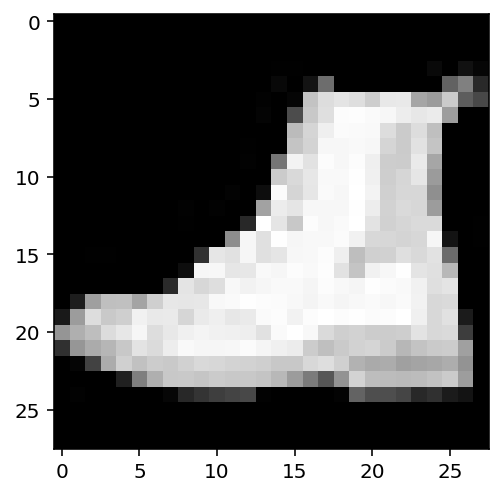

In [6]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

In [0]:
class MLP(nn.Module):
  def __init__(self, input_size=28*28, hidden_1=256,
               hidden_2=128,hidden_3=64,output=10, dropout=False):
    super().__init__()

    # 2 hidden and ne output layer
    self.fc1=nn.Linear(input_size, hidden_1)
    self.fc2=nn.Linear(hidden_1, hidden_2)
    self.fc3=nn.Linear(hidden_2, hidden_3)
    self.fc4=nn.Linear(hidden_3, output)

    self.relu=nn.ReLU()
    self.softmax=nn.LogSoftmax(dim=1)
    self.dropout_bool=dropout
    if self.dropout_bool:
      self.dropout=nn.Dropout(p=0.2)
  # optionally adding a dropout layer
  # def add_dropout(self,x):
  #   if self.dropout_bool:
  #     x=self.dropout(x)
  #   return x

  def forward(self,x):
    print(x.shape)
    x=x.view(x.shape[0],-1)
    print(x.shape)
    x=self.relu(self.fc1(x))
    if self.dropout_bool:
      x=self.dropout(x)
    x=self.relu(self.fc2(x))
    if self.dropout_bool:
      x=self.dropout(x)
    x=self.relu(self.fc3(x))
    if self.dropout_bool:
      x=self.dropout(x)
    x=self.softmax(self.fc4(x))

    return x

## Part II: Building a flexible model

In [0]:
class MLP_extend(MLP):
  def __init__(self, input_size=28*28, hidden_1=256,
               hidden_2=128,hidden_3=64,output=10,
               epochs=30, lr=0.001,dropout=False):
    super().__init__(input_size, hidden_1,
               hidden_2,hidden_3,output,dropout)
    
    self.lr=lr
    self.optim=optim.Adam(self.parameters(), self.lr)

    self.epochs=epochs

    self.criterion=nn.NLLLoss()

    self.loss_during_training=[]
    self.validation_loss=[]
    self.accuracy=[]
    self.test_accuracy=0

    self.early_stopp=0
    
# creating a function that once every epoch creates a validation loss and computes the accuracy on the validation set
  def validate(self,validloader):
    if(train_on_gpu):
        self.cuda()
    self.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for images,labels in validloader:
          images,labels=images.cuda(), labels.cuda()
          log_proba = self.forward(images)
          loss = self.criterion(log_proba, labels)
          test_loss +=loss

          proba = torch.exp(log_proba)
          top_p, top_c = proba.topk(1, dim=1)
          equals = top_c ==labels.view(*top_c.shape)
          accuracy +=torch.mean(equals.type(torch.FloatTensor))
        else:
          self.validation_loss.append(test_loss/len(validloader))
          self.accuracy.append(accuracy/len(validloader))
                    
          print("Validation loss: {}" .format(self.validation_loss[-1]))
          print("Accuracy : {}" .format(self.accuracy[-1]))

          self.train()

  
  def test(self, testloader):
    if(train_on_gpu):
        self.cuda()
    self.eval()
    counter=0

    for images, labels in trainloader:  
      images,labels=images.cuda(), labels.cuda()
      log_proba=self.forward(images)
      proba = torch.exp(log_proba)
      top_p, top_c = proba.topk(1, dim=1)
      equals = top_c ==labels.view(*top_c.shape)
      self.test_accuracy+=torch.mean(equals.type(torch.FloatTensor))
      counter+=1
    
    else:
      print('Accuracy on test set of current model is: {}'.format(self.test_accuracy/counter))

  
  def train_loop(self,trainloader,validloader = None,early_stopping=False):
    if(train_on_gpu):
        self.cuda()
    self.train()
        
    for e in range(int(self.epochs)):
        running_loss = 0.
        for images, labels in trainloader:  
          images,labels=images.cuda(), labels.cuda()          
          self.optim.zero_grad()
          out = self.forward(images)
                  
          loss = self.criterion(out, labels)
          running_loss += loss.item()

          loss.backward()
          self.optim.step() 
                  
        else:
          self.loss_during_training.append(running_loss/len(trainloader))
      
                  
          print("Training loss after {} epochs: {}" .format(e+1,self.loss_during_training[-1]))
          if validloader:
            self.validate(validloader)
            # condition for early stopping
            # if validation loss increases three times in a row--> we stop
            try:
              if early_stopping and self.validation_loss[-1]>self.validation_loss[-2] :
                self.early_stopp+=1
              else:
                self.early_stopp=0
            except:
              IndexError
            if  self.early_stopp>=2:
              return


## Part III: Overfitting and Regularization

In [10]:
# simple model to show the effects of overfitting
model=MLP_extend(epochs=30)
print(model)

MLP_extend(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax()
  (criterion): NLLLoss()
)


In [11]:
model.train_loop(trainloader, validloader,early_stopping=False)

torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])


KeyboardInterrupt: ignored

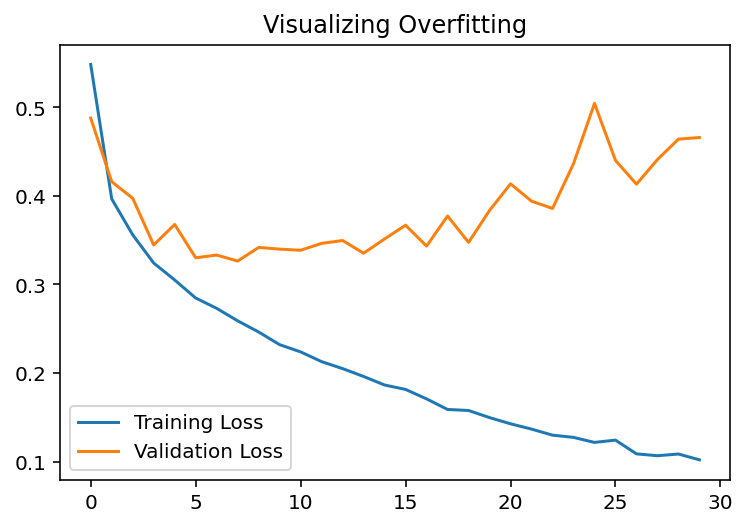

In [0]:
plt.plot(model.loss_during_training, label='Training Loss')
plt.plot(model.validation_loss, label='Validation Loss')
plt.title('Visualizing Overfitting')
plt.legend()
plt.show()
plt.close()

In [0]:
model.test(testloader)

Accuracy on test set of current model is: 0.9656649231910706


We can see that the validation loss is a concave function and that overfitting occurs round about the 10th epoch. However, we also see that 
One bad validation score can be a fluke and should not lead to early stopping,

In [0]:
model_early=MLP_extend()
model_early.train_loop(trainloader, validloader,early_stopping=True)


Training loss after 1 epochs: 0.5455718662124127
Validation loss: 0.4579978287220001
Accuracy : 0.8256427645683289
Training loss after 2 epochs: 0.3931434828237715
Validation loss: 0.39346736669540405
Accuracy : 0.8525709509849548
Training loss after 3 epochs: 0.3520967704032294
Validation loss: 0.38561517000198364
Accuracy : 0.8582668304443359
Training loss after 4 epochs: 0.326086615328677
Validation loss: 0.35178229212760925
Accuracy : 0.8715204000473022
Training loss after 5 epochs: 0.3016709255753085
Validation loss: 0.34419602155685425
Accuracy : 0.8772162795066833
Training loss after 6 epochs: 0.2871171763293784
Validation loss: 0.33699432015419006
Accuracy : 0.875465452671051
Training loss after 7 epochs: 0.2718342208748006
Validation loss: 0.34191763401031494
Accuracy : 0.880651593208313
Training loss after 8 epochs: 0.25879714658102865
Validation loss: 0.32658854126930237
Accuracy : 0.8782579898834229
Training loss after 9 epochs: 0.24648070997897198
Validation loss: 0.349862

In [0]:
model_early.test(testloader)

Accuracy on test set of current model is: 0.8940207958221436


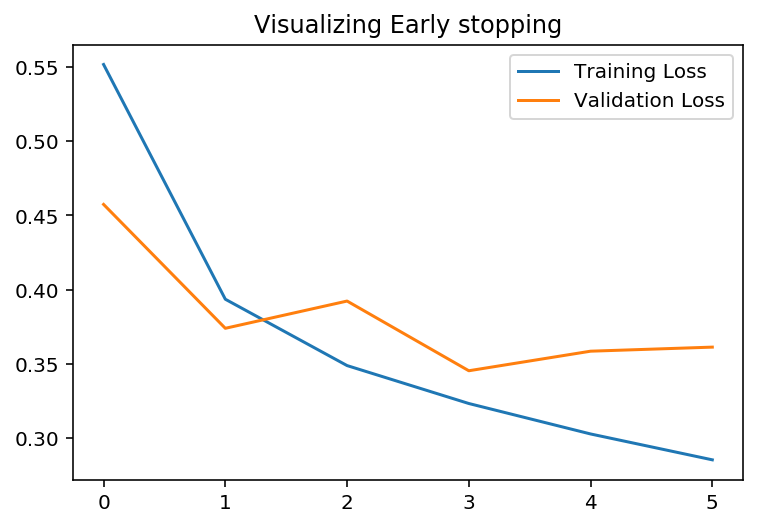

In [0]:
plt.plot(model_early.loss_during_training, label='Training Loss')
plt.plot(model_early.validation_loss, label='Validation Loss')
plt.title('Visualizing Early stopping')
plt.legend()
plt.show()
plt.close()

While Early Stopping does stop training as it is supposed at iteration 10 its performance on the test set is poorer than that of the model that was allowed to train for all 30 epochs.

In [0]:
model_dropout=MLP_extend(dropout=True)
model_dropout.train_loop(trainloader, validloader,early_stopping=False)


Training loss after 1 epochs: 0.6453636951575225
Validation loss: 0.44932547211647034
Accuracy : 0.8363475203514099
Training loss after 2 epochs: 0.4563802165529606
Validation loss: 0.42505526542663574
Accuracy : 0.8382092118263245
Training loss after 3 epochs: 0.4111560284879736
Validation loss: 0.39680016040802
Accuracy : 0.8547872304916382
Training loss after 4 epochs: 0.38183720934797416
Validation loss: 0.35916030406951904
Accuracy : 0.8725177645683289
Training loss after 5 epochs: 0.3639064649839632
Validation loss: 0.34966060519218445
Accuracy : 0.8737145662307739
Training loss after 6 epochs: 0.34951334520751104
Validation loss: 0.3450450301170349
Accuracy : 0.8769946694374084
Training loss after 7 epochs: 0.33994375078261574
Validation loss: 0.3306431472301483
Accuracy : 0.8788342475891113
Training loss after 8 epochs: 0.3277003875912421
Validation loss: 0.34232598543167114
Accuracy : 0.8773714900016785
Training loss after 9 epochs: 0.3185618137517436
Validation loss: 0.330405

In [0]:
model_dropout.test(testloader)

Accuracy on test set of current model is: 0.9363680481910706


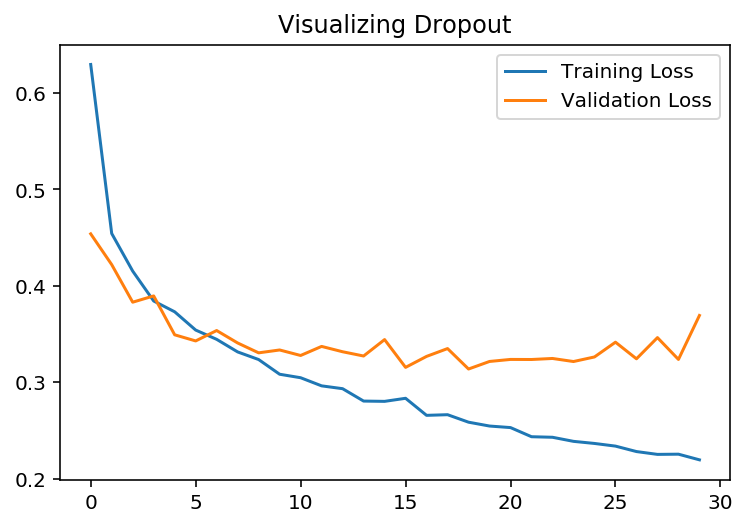

In [0]:
plt.plot(model_dropout.loss_during_training, label='Training Loss')
plt.plot(model_dropout.validation_loss, label='Validation Loss')
plt.title('Visualizing Dropout')
plt.legend()
plt.show()
plt.close()

While the model with dropout is able to keep the validation loss low across 30 epochs (0.33 vs. 0.41) it does perform poorer on the test set then the model without dropout.